In [2]:
# Comment out as we already have the packages
# Acquire prerequisite packages
# !pip install gdown
# !pip install imbalanced-learn
# !pip install --upgrade seaborn

# # install full version
# !pip install pycaret[full]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 3.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.0
    Uninstalling seaborn-0.13.0:
      Successfully uninstalled seaborn-0.13.0


In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

from imblearn.over_sampling import SMOTENC

from pycaret.classification import *

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings

import gdown

warnings.filterwarnings('ignore')

In [2]:
random_seed = 202406

In [3]:
# Comment out as we already have the raw data downloaded previously

# gdown.download('https://drive.google.com/uc?id=1cq3EBN238kBUW4R0u4rDYlyv9HqvqsDo', './card_transdata.csv')

Downloading...
From: https://drive.google.com/uc?id=1cq3EBN238kBUW4R0u4rDYlyv9HqvqsDo
To: /home/jovyan/workspace/card_transdata.csv
100%|██████████| 76.3M/76.3M [01:06<00:00, 1.15MB/s]


'./card_transdata.csv'

In [3]:
df_credit_card_fraud_org = pd.read_csv('./card_transdata.csv', sep=',', header=0, index_col=False, engine='python')

In [4]:
df_credit_card_fraud_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [6]:
df_credit_card_fraud_org.describe(include='all', percentiles=[0.01, 0.05, 0.07, 0.1, 0.25, 0.5, 0.75, 0.9, 0.93, 0.95, 0.99])

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
1%,0.382177,0.015167,0.077271,0.000000,0.000000,0.000000,0.000000,0.000000
5%,0.997655,0.051396,0.163934,0.000000,0.000000,0.000000,0.000000,0.000000
7%,1.263950,0.069777,0.197321,0.000000,0.000000,0.000000,0.000000,0.000000
10%,1.654928,0.099247,0.244159,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000


In [38]:
# Split data based on the proportion of fraud and other categorical features

df_credit_card_fraud_split = df_credit_card_fraud_org.copy()

# Create a new feature called "card_present" which is deducted by used_chip and used_pin_number feature
df_credit_card_fraud_split['card_present'] = df_credit_card_fraud_split[['used_chip', 'used_pin_number']].max(axis=1)
df_credit_card_fraud_split.drop(columns=['used_chip', 'used_pin_number'], inplace=True)
# Obtain the index of the split and apply it to the original dataframe
_train, _test = train_test_split(df_credit_card_fraud_split, test_size=0.1, random_state=random_seed, shuffle=True, stratify=df_credit_card_fraud_split[['repeat_retailer', 'online_order', 'card_present', 'fraud']])

dX_train = (df_credit_card_fraud_org.copy().loc[_train.index.to_list()]).drop(['fraud'], axis=1)
dX_test = (df_credit_card_fraud_org.copy().loc[_test.index.to_list()]).drop(['fraud'], axis=1)
dY_train = (df_credit_card_fraud_org.copy().loc[_train.index.to_list()])['fraud']
dY_test = (df_credit_card_fraud_org.copy().loc[_test.index.to_list()])['fraud']

print(dX_train.shape)
print(dX_test.shape)
print(dY_train.shape)
print(dY_test.shape)

(900000, 7)
(100000, 7)
(900000,)
(100000,)


In [42]:
dY_test.head(15)

391302    0.0
529830    1.0
538452    0.0
486873    0.0
795614    0.0
72031     0.0
214301    0.0
373009    0.0
439128    0.0
772233    0.0
748787    0.0
711907    1.0
404340    0.0
541975    0.0
309850    0.0
Name: fraud, dtype: float64

In [44]:
# define features of various types:

numerical_features = ["distance_from_home", "distance_from_last_transaction", "ratio_to_median_purchase_price"]
categorical_features = ["repeat_retailer ", "used_chip", "used_pin_number", "online_order"]

y = ["fraud"]

dX_train_numerical = dX_train[numerical_features]

dX_train_numerical.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price
count,900000.000000,900000.000000,900000.000000
mean,26.624983,5.035051,1.824269
std,65.470354,23.115339,2.807670
min,0.004874,0.000118,0.005741
25%,3.881021,0.296844,0.475815
50%,9.963836,0.999289,0.997559
75%,25.728037,3.356552,2.095094
max,10632.723672,4968.315477,267.802942


In [51]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaling = StandardScaler()

# Use fit and transform method 
scaling.fit(dX_train_numerical)
dX_train_scaled = scaling.transform(dX_train_numerical)

dX_train_scaled.shape
type(dX_train_scaled)
print(dX_train_scaled)

[[-0.3344331  -0.17759724  3.05645444]
 [-0.18091756  0.00884023 -0.54953427]
 [-0.3548126  -0.21219161  0.08721445]
 ...
 [-0.17200926 -0.08986779 -0.35148114]
 [-0.39427603 -0.20674689 -0.60053911]
 [-0.26840443 -0.15610664 -0.12225392]]


In [57]:
# Set number of components to 1 since we only have 3 numerical features
pca = PCA(n_components=1)
pca.fit(dX_train_scaled)
x=pca.transform(dX_train_scaled)
 
# Check the dimensions of data after PCA
print(x.shape)

(900000, 1)


In [61]:
# Let's see the effect of PCA
import numpy as np

variance = []
for i in range(len(numerical_features) + 1):
    #print(f"i={i}")
    pca = PCA(n_components=i)
    pca.fit(dX_train_scaled)
    variance.append(np.sum(pca.explained_variance_ratio_))

Text(0.5, 1.0, '# of Components Effect on Explained Variance')

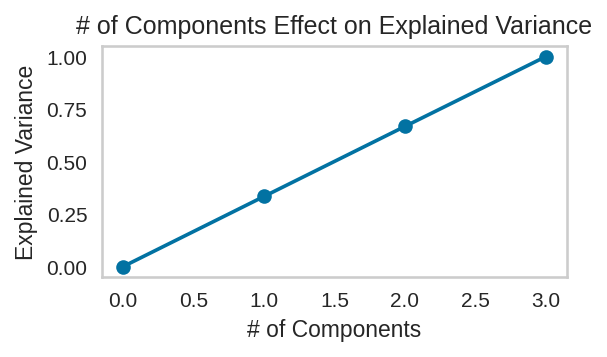

In [62]:
# Plot effect of PCA

import matplotlib.pyplot as plt

plt.figure(figsize=(4,2),dpi=150)
plt.grid()
plt.plot(range(len(numerical_features) + 1), variance, marker='o')
plt.xlabel('# of Components')
plt.ylabel('Explained Variance')
plt.title('# of Components Effect on Explained Variance')

In [ ]:
# As demonstrated in the plot, there is no apparent benefit to apply PCA on this dataset which only has 3 features.